In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime, timedelta
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, r2_score, recall_score, auc, roc_curve, precision_score, mean_absolute_error
from sklearn.model_selection import train_test_split, ShuffleSplit, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
def round2(num, r=2):
    return round(num, r)
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.metrics import BinaryCrossentropy, Precision
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU, Input, LSTM, Bidirectional
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
data=pd.read_csv('train.csv', index_col = 'id')

In [10]:
df=data.copy()
df.rename(columns={'height(cm)': 'height',  'weight(kg)':'weight','waist(cm)': 'waist', 'eyesight(left)': 'eyesight_left',
'eyesight(right)': 'eyesight_right',    'hearing(left)': 'hearing_left', 'hearing(right)': 'hearing_right',
'fasting blood sugar': 'blood_sugar',    'Urine protein': 'Urine_protein', 'serum creatinine': 'serum_creatinine',
'dental caries': 'dental_caries'}, inplace=True)
df.head(5)

,age,height,weight,waist,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,...,HDL,LDL,hemoglobin,Urine_protein,serum_creatinine,AST,ALT,Gtp,dental_caries,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [11]:
df.columns

Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation',
       'blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL',
       'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp',
       'dental_caries', 'smoking'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               159256 non-null  int64  
 1   height            159256 non-null  int64  
 2   weight            159256 non-null  int64  
 3   waist             159256 non-null  float64
 4   eyesight_left     159256 non-null  float64
 5   eyesight_right    159256 non-null  float64
 6   hearing_left      159256 non-null  int64  
 7   hearing_right     159256 non-null  int64  
 8   systolic          159256 non-null  int64  
 9   relaxation        159256 non-null  int64  
 10  blood_sugar       159256 non-null  int64  
 11  Cholesterol       159256 non-null  int64  
 12  triglyceride      159256 non-null  int64  
 13  HDL               159256 non-null  int64  
 14  LDL               159256 non-null  int64  
 15  hemoglobin        159256 non-null  float64
 16  Urine_protein     15

In [13]:
df.smoking.unique()

array([1, 0], dtype=int64)

## Qick check for correlation of target with features

In [14]:
corr_numpy = df.drop(columns=['smoking']).corrwith(df.smoking)
type(corr_numpy)
# corr_numpy

pandas.core.series.Series

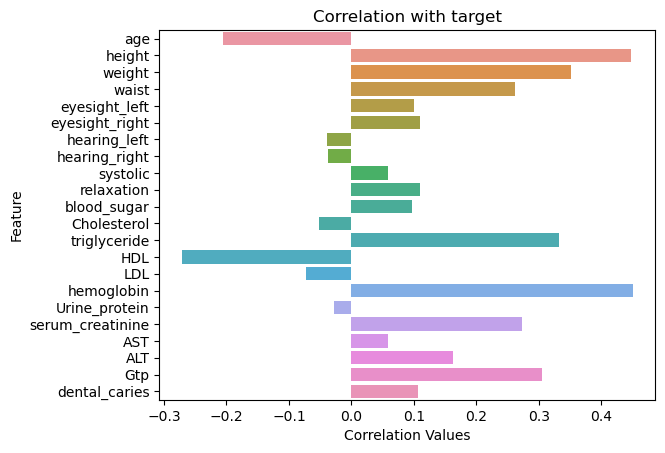

In [15]:
sns.barplot(x=corr_numpy.values, y=corr_numpy.index)
plt.xlabel('Correlation Values')
plt.ylabel('Feature')
plt.title('Correlation with target')
plt.show()

## Check of incorrect data:

<AxesSubplot:>

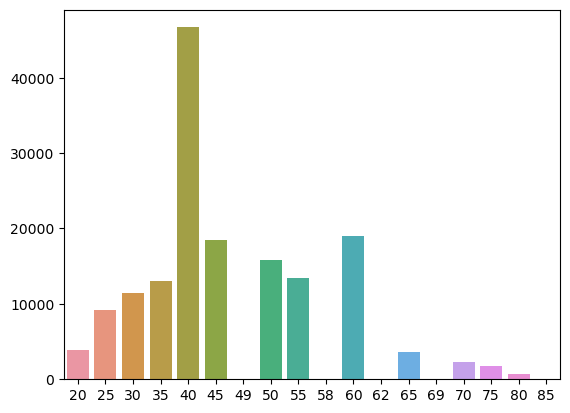

In [16]:
age_plot_data = pd.Series(df.age.value_counts())
sns.barplot(y=age_plot_data.values, x=age_plot_data.index)

In [17]:
# fixing features that are out of bucket (rounding it down)
for col in ['age', 'height', 'weight']:
    df[col] = df[col] - df[col] % 5

In [18]:
# df[df.eyesight_left == 9.9][['eyesight_left', 'eyesight_right']]

## Adding features

In [19]:
df.columns

Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation',
       'blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL',
       'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp',
       'dental_caries', 'smoking'],
      dtype='object')

In [20]:
def create_fearures(df):
    df['w_h_ratio'] = df.weight / df.height
    df['w_w_ratio'] = df.weight / df.waist
    systolic_norm = 120  # < less then 120 is norm
    relaxation_norm = 90  # < less then 90 is norm
    df['blood_sugar_devn'] = df.blood_sugar - 85
    df['Cholesterol_norm'] = np.where(df.Cholesterol <= 200, 0
                                      , np.where((df.Cholesterol > 200) & (df.Cholesterol < 240), 1
                                                ,np.where(df.Cholesterol >= 240,2, 9)))
    df['triglyceride_norm'] = np.where(df.triglyceride <=150 , 0,
                                       np.where((df.triglyceride > 150) & (df.triglyceride < 200), 1,2))
    HDL_norm = 60 #above is good
    LDL_norm = 100 #below is good
    LDLHDL_total_norm = 200 # HDL + LDL should be beloww 200 
    df['HDL_deviation'] = df.HDL - HDL_norm
    df['LDL_deviation'] = df.LDL - LDL_norm
    df['LDLHDL_total_dev'] = df.HDL + df.HDL - LDLHDL_total_norm
    df['hemoglobin_norm'] = np.where((df.hemoglobin > 120) & (df.hemoglobin < 160), 1,0)
    df['serum_creatinine_dev'] = df.serum_creatinine - 0.8
create_fearures(df)   

In [21]:
# df.Gtp.unique()

In [22]:
list_of_null_cols = [feat for feat in df.columns if df[feat].isnull().any().sum() > 0]
list_of_nulls = {feat: df[feat].isnull().sum()  for feat in df.columns if df[feat].isnull().any().sum() > 0}
list_of_nulls

{}

## Test df

In [23]:
test_df=pd.read_csv('test.csv', index_col = 'id')
test_df.rename(columns={'height(cm)': 'height',  'weight(kg)':'weight','waist(cm)': 'waist', 'eyesight(left)': 'eyesight_left',
'eyesight(right)': 'eyesight_right',    'hearing(left)': 'hearing_left', 'hearing(right)': 'hearing_right',
'fasting blood sugar': 'blood_sugar',    'Urine protein': 'Urine_protein', 'serum creatinine': 'serum_creatinine',
'dental caries': 'dental_caries'}, inplace=True)
for col in ['age', 'height', 'weight']:
    test_df[col] = test_df[col] - test_df[col] % 5
create_fearures(test_df) 

# Model

In [24]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(df.drop(['smoking'], axis = 1)
                                                    , df.smoking, shuffle= True)

num_cols = df.drop(['smoking'], axis = 1).columns[X_train.dtypes != object].tolist()
# X_train[num_cols].info()

In [77]:
cl = list()
for i in range(560):
    cl.append('col_%s' %i)

X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols]), columns = cl, index = X_train.index)
X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols]), columns = cl, index = X_test.index)

X_train = X_train.join(X_train_polyed)
X_test = X_test.join(X_test_polyed)

test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols]), columns = cl, index = test_df.index)
test_df1 = test_df.join(test_df_polyed)#.drop(['smoking'], axis = 1)
X_train.shape

(119442, 592)

In [93]:
train_dataset = Pool(data = X_train#.drop(columns = ['Id']),
                     ,label = y_train.astype(bool),
#                      cat_features=categ_features
                    )

eval_dataset = Pool(data = X_test#.drop(columns = ['Id']),
                     ,label = y_test.astype(bool),
#                     cat_features=categ_features
                   )

In [83]:
cat_model = CatBoostClassifier(verbose = 0, eval_metric='AUC', iterations = 50,
                              # plot=True,
                              )

In [84]:
%%time
cat_model.fit(train_dataset, plot=True, eval_set = eval_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 54.1 s


In [85]:
train_preds = cat_model.predict(X_train)
test_preds = cat_model.predict(X_test)

In [86]:
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(train_preds, y_train)))
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(test_preds, y_test)))
# 0.

Правильность на обучающем наборе: 0.794
Правильность на обучающем наборе: 0.776


In [55]:
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(train_preds, y_train)))
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(test_preds, y_test)))
# 0.

Правильность на обучающем наборе: 0.826
Правильность на обучающем наборе: 0.784


In [87]:
fin_pred_cat = cat_model.predict_proba(test_df1)[:, 1]

In [88]:
fin_pred_2= pd.DataFrame({'id': test_df.index, 'smoking': fin_pred_cat})
fin_pred_2.to_csv('submission_cat.csv', index = False)

In [116]:
from sklearn.svm import LinearSVC

# Adding stacking

In [132]:
estimators = [
     ('rf', RandomForestClassifier(n_estimators=500)),
     ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42))),
    ('cat1', CatBoostClassifier(verbose = 0, eval_metric='AUC', iterations = 1100))
    ,('cat2', CatBoostClassifier(verbose = 0, eval_metric='AUC', iterations = 1000))
    ,('cat3', CatBoostClassifier(verbose = 0, eval_metric='AUC', iterations = 500))
    ,('cat4', CatBoostClassifier(verbose = 0, eval_metric='Precision', iterations = 500))
 ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=CatBoostClassifier(verbose = 1, eval_metric='AUC', iterations = 500,
#                                cat_features=categ_features
                                                           ))

In [133]:
%%time
clf.fit(X_train, y_train)#.score(X_test, y_test) 

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Learning rate set to 0.149942
0:	total: 36.8ms	remaining: 18.4s
1:	total: 71.4ms	remaining: 17.8s
2:	total: 106ms	remaining: 17.5s
3:	total: 138ms	remaining: 17.1s
4:	total: 172ms	remaining: 17s
5:	total: 211ms	remaining: 17.4s
6:	total: 247ms	remaining: 17.4s
7:	total: 289ms	remaining: 17.8s
8:	total: 323ms	remaining: 17.6s
9:	total: 353ms	remaining: 17.3s
10:	total: 388ms	remaining: 17.2s
11:	total: 420ms	remaining: 17.1s
12:	total: 462ms	remaining: 17.3s
13:	total: 507ms	remaining: 17.6s
14:	total: 551ms	remaining: 17.8s
15:	total: 584ms	remaining: 17.7s
16:	total: 617ms	remaining: 17.5s
17:	total: 651ms	remaining: 17.4s
18:	total: 688ms	remaining: 17.4s
19:	total: 730ms	remaining: 17.5s
20:	total: 768ms	remaining: 17.5s
21:	total: 802ms	remaining: 17.4s
22:	total: 834ms	remaining: 17.3s
23:	total: 868ms	remaining: 17.2s
24:	total: 906ms	remaining: 17.2s
25:	total: 948ms	remaining: 17.3s
26:	total: 988ms	remaining: 17.3s
27:	total: 1.02s	remaining: 17.2s
28:	total: 1.05s	remaining: 

StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=500)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))])),
                               ('cat1',
                                <catboost.core.CatBoostClassifier object at 0x0000020483C5D5E0>),
                               ('cat2',
                                <catboost.core.CatBoostClassifier object at 0x0000020483C5D640>),
                               ('cat3',
                                <catboost.core.CatBoostClassifier object at 0x0000020483C5D130>),
                               ('cat4',
                                <catboost.core.CatBoostClassifier object at 0x0000020483C5D940>)],
                   final_estimator=<catboost.core

In [134]:
train_preds1 = clf.predict(X_train)
test_preds1 = clf.predict(X_test)
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(train_preds1, y_train)))
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(test_preds1, y_test)))#.astype(bool)

Правильность на обучающем наборе: 0.807
Правильность на обучающем наборе: 0.783


In [128]:
test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols]), columns = cl, index = test_df.index)
test_df1 = test_df.join(test_df_polyed)#.drop(['smoking'], axis = 1)

In [129]:
fin_pred_2 = clf.predict_proba(test_df)[:, 1]

In [130]:
fin_pred_2= pd.DataFrame({'id': test_df.index, 'smoking': fin_pred_2})
fin_pred_2.to_csv('submission_stack.csv', index = False)
# fin_pred_2 = test_df.index.join(pd.DataFrame(fin_pred_2, columns = ['Probability']))
# тот же результат

# NN

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
mns = MinMaxScaler()

In [26]:
# poly = PolynomialFeatures(degree=2, include_bias=False, )

X_train, X_test, y_train, y_test = train_test_split(df.drop(['smoking'], axis = 1)
                                                    , df.smoking, shuffle= True)

num_cols = df.drop(['smoking'], axis = 1).columns[X_train.dtypes != object].tolist()

In [204]:
cl = list()
for i in range(275):
    cl.append('col_%s' %i)

X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols]), columns = cl, index = X_train.index)
X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols]), columns = cl, index = X_test.index)

X_train = X_train.join(X_train_polyed)
X_test = X_test.join(X_test_polyed)

test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols]), columns = cl, index = test_df.index)
test_df1 = test_df.join(test_df_polyed)#.drop(['smoking'], axis = 1)
X_train.shape

(119442, 297)

In [28]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
test_df_scaled = sc.transform(test_df) # test_df1 for poly

In [29]:
list_of_null_cols = [feat for feat in X_train.columns if X_train[feat].isnull().any().sum() > 0]
list_of_nulls = {feat: X_train[feat].isnull().sum()  for feat in X_train.columns if X_train[feat].isnull().any().sum() > 0}
list_of_nulls

{}

In [48]:
seq_model = Sequential()
# seq_model.add(Dense(units = 30, activation= 'tanh'))
# seq_model.add(Dropout(0.2))
seq_model.add(Dense(units = 130, activation= 'sigmoid'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(units = 130, activation= 'LeakyReLU'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(units = 1, activation= 'sigmoid'))
es = EarlyStopping(monitor='val_auc', mode='max', min_delta = 0.0005,verbose=1, patience=25)
mc = ModelCheckpoint('seq_model.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)

seq_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['AUC'])

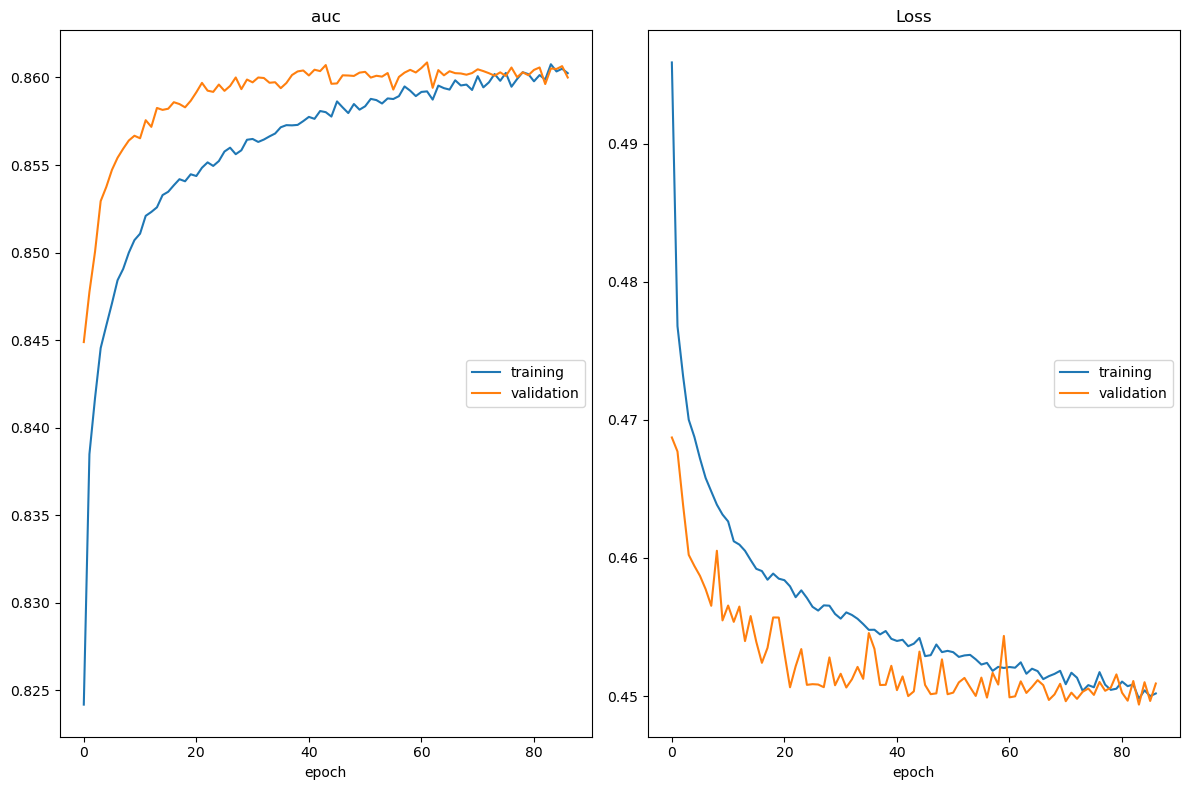

auc
	training         	 (min:    0.824, max:    0.861, cur:    0.860)
	validation       	 (min:    0.845, max:    0.861, cur:    0.860)
Loss
	training         	 (min:    0.450, max:    0.496, cur:    0.450)
	validation       	 (min:    0.449, max:    0.469, cur:    0.451)

Epoch 87: val_auc did not improve from 0.86086
3733/3733 [==============================] - 16s 4ms/step - loss: 0.4502 - auc: 0.8602 - val_loss: 0.4509 - val_auc: 0.8600
Epoch 87: early stopping


In [49]:
model_hist = seq_model.fit(X_train_scaled, y_train, epochs=100
                     , batch_size = 24
                    ,validation_data=(X_test_scaled, y_test)
                     # ,inp
                     , callbacks=[PlotLossesKeras(), es, mc]
                    )

In [50]:
seq_model = load_model('seq_model.h5')
train_proba = seq_model.predict(X_train_scaled)
test_proba = seq_model.predict(X_test_scaled)

train_preds_seq = np.where(train_proba[:, 0] >= 0.5, 1, 0)
test_preds_seq = np.where(test_proba[:, 0] >= 0.5, 1, 0)
print('Правильность на train наборе: {:.3f}'.format(roc_auc_score(train_preds_seq, y_train)))
print('Правильность на test наборе: {:.3f}'.format(roc_auc_score(test_preds_seq, y_test)))

1245/1245 [==============================] - 3s 2ms/step
Правильность на train наборе: 0.781
Правильность на test наборе: 0.778


In [51]:
print('Правильность на train наборе: {:.3f}'.format(roc_auc_score(train_preds_seq, y_train)))
print('Правильность на test наборе: {:.3f}'.format(roc_auc_score(test_preds_seq, y_test)))

Правильность на train наборе: 0.781
Правильность на test наборе: 0.778


In [52]:
seq_proba = seq_model.predict(test_df_scaled)[:, 0]
seq_proba

3318/3318 [==============================] - 8s 2ms/step


array([0.6126645 , 0.28826132, 0.40921035, ..., 0.47173068, 0.12494411,
       0.03192926], dtype=float32)

In [53]:
seq_pred_2= pd.DataFrame({'id': test_df.index, 'smoking': seq_proba})
seq_pred_2.to_csv('submission_seq.csv', index = False)